# Import Packages and functions

C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\FunctionsAndClass.py:12: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


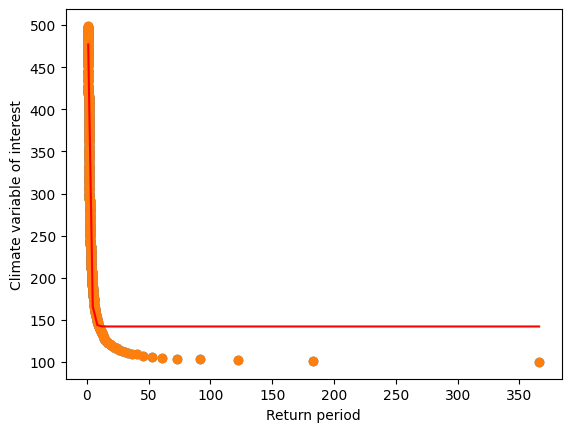

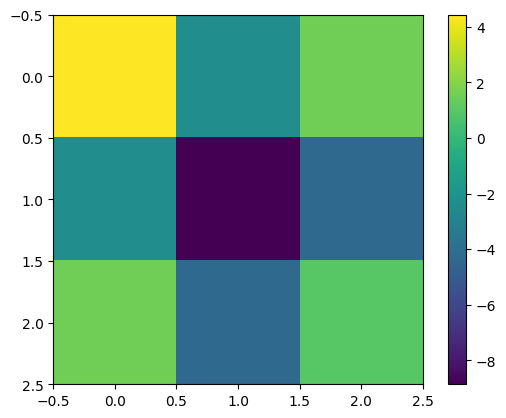

In [1]:
import requests
import pandas as pd

import os
import os.path

from netCDF4 import Dataset


import numpy as np
import numpy.ma as ma

# to measure elapsed time
import time
from timeit import default_timer as timer

import multiprocessing as mp# to download several file in parrallel
from multiprocessing.pool import ThreadPool

from FileManagement1 import produce_name_list
from FunctionsAndClass import year_copernicus
from FileManagement1 import find_path_file
from FileManagement1 import find_column_name
from FileManagement1 import time_vector_conversion
from FileManagement1 import create_dataframe
from FileManagement1 import data_information
from FileManagement1 import df_to_csv
from FileManagement1 import read_nc_file

# Projects information


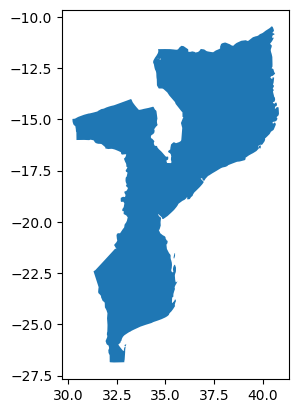

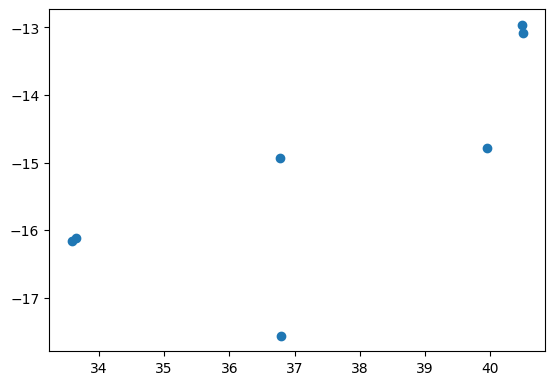

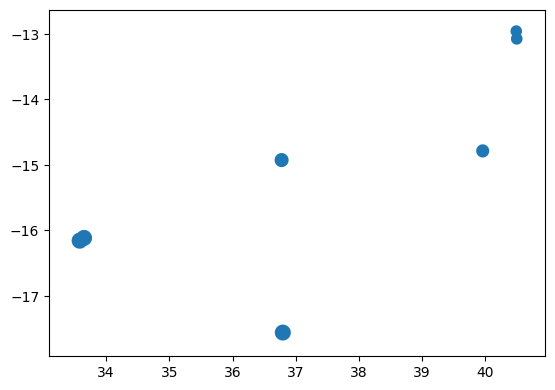

In [2]:
import geopandas as gpd
import os
import os.path

data_folder=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
project_location_path=os.path.join(data_folder,'Mozambique_PPIS/EIB_locations_few.shp')
#study boundary (optional)
study_area_path=os.path.join(data_folder,'Mozambique_PPIS/mozambique.shp')


#projection CRS (default = 'EPSG:4326')
bCRS='EPSG:4326'

#buffer for climate/grid variables
buffer=40000 #buffer in meters, 0 = no buffer is computed

mCRS='EPSG:31983' #metric CRS for buffer in meters (find relevant metric CRS for location!)

#load shapefiles
projects = gpd.read_file(project_location_path).to_crs(bCRS)
project_id='Name' #name of column used as id

study_area = gpd.read_file(study_area_path).to_crs(bCRS)

#calculate buffer around points/shape
if buffer != 0:
    projects_buf=projects.to_crs(mCRS)  #project to crs with metric units to get buffer in meters
    projects_buf['geometry']=projects.to_crs(mCRS).buffer(buffer) #assign the buffer as the new geometry - 
    projects_buf=projects_buf.to_crs(bCRS)#project back to orginal crs

    
#plot shapefiles
study_area.plot()
projects.plot()
projects_buf.plot() 


#show table
projects[[project_id]]
# prepare name_project for use 
name_project = projects['Name'].str.replace(' ','_') # take off every blank space of project names
name_project = name_project.str.replace('(','') # take off every ( of project names
name_project = name_project.str.replace(')','') # take off every ) of project names
name_project = name_project.str.replace('-','') # take off every - of project names
name_project = name_project.str.replace('/','_') # take off every / of project names
name_project = name_project.str.replace(r'"\"','_') # take off every \ of project names

# register geographic information concerning projects
lon_projects = projects['geometry'].x
lat_projects = projects['geometry'].y
buf_projects = 0.3
area_projects = [lat_projects - buf_projects, lat_projects+buf_projects, lon_projects-buf_projects,lon_projects+buf_projects] # list format
#### determination of the geographical zone of interest 
lat_min_wanted = min(study_area['LAT'])-10
lat_max_wanted = max(study_area['LAT'])+10
lon_min_wanted = min(study_area['LON'])-20
lon_max_wanted = max(study_area['LON'])+20
# addind and substracting to lon and lat to have margin
# substracting more to longitude because the range of longitude is -180 to 180. The range of latitude is -90 to 90

In [3]:
len(lon_projects)

7

In [4]:
lon_projects

0    33.651626
1    33.582722
2    39.956305
3    36.776066
4    36.795077
5    40.487087
6    40.494835
dtype: float64

# Define Paths

In [5]:
out_path=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6'

# Complete list of url with files to download

In [6]:
# register information from csv file
#all_urls = pd.read_csv(r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\NEX-GDDP-CMIP6\gddp-cmip6-thredds-fileserver.csv')
csv_path = os.path.join(out_path,'gddp-cmip6-thredds-fileserver.csv')
all_urls = pd.read_csv(csv_path)

In [7]:
### make all elements of the csv into a readable list

temp_list = all_urls[[' fileUrl']].T# transpose csv
temp_list=temp_list.values.tolist()
temp_list=temp_list[0]
url_list=[s.replace(' ', '') for s in temp_list]

In [8]:
## download only precipitation data
# select only precipitation files, between 2040 and 2080
url_list_precipitation = [url for url in url_list if 'pr_day_' in url and int(url[len(url)-7:len(url)-3])>2020 and int(url[len(url)-7:len(url)-3])<2061 and 'r1i1p1f1_gn' in url]

In [9]:
len(url_list_precipitation)

2360

In [10]:
name_list_precipitation = produce_name_list(url_list_precipitation)

# Produce csv files with data to use

In [11]:
(year, year_str, index_year) = year_copernicus(2021,2022)

In [12]:
variables= []
time_aggregations= []
models= []
scenarios= []
for file_name in name_list_precipitation:
    (variable, time_aggregation, model, scenario, year) = data_information(file_name) 
    # use function data_information to find information concerning the file_name
    if variable not in variables:
        variables.append(variable)
    if time_aggregation not in time_aggregations:
        time_aggregations.append(time_aggregation)
    if model not in models:
        models.append(model)
    if scenario not in scenarios:
        scenarios.append(scenario)
title_file = variable +'_'+year_str[0] +'_'+year_str[len(year_str)-1]
name_variable = 'pr_day'

In [13]:
# count time

In [14]:
i = 0
df = pd.DataFrame() # create an empty dataframe
title_file = name_project[i]+'_2021-2022'+'.csv'
#area_project = [area_projects[0][i],area_projects[1][i],area_projects[2][i],area_projects[3][i]]
start = time.time()
df=create_dataframe(name_list_precipitation,'daily',year_str,[scenarios[0]],[models[0]],out_path, name_variable, name_project[i],lon_projects[0],lat_projects[0],df)
# return df and final path of csv
path_csv = df_to_csv(df,out_path,title_file,name_variable,'2021-2022')
end = time.time()
print('----- Time to execute the function create_dataframe with one model and one scenario: ' + str(end - start) +' seconds -------- ')
print('\n')

For the year 2021, test with scenario ssp245 and with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2021.nc']
Registering the data in a dataframe


Time to execute the function get_data_nc for the variable pr: 7.297563200001605 seconds


Time to register one year in a dataframe: 3.201265499999863 seconds


Time to execute the function register_data: 10.736470700001519 seconds


For the year 2022, test with scenario ssp245 and with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2022.nc']
Registering the data in a dataframe


Time to execute the function get_data_nc for the variable pr: 9.26991519999865 seconds


Time to register one year in a dataframe: 2.0194080000001122 seconds


Time to execute the function register_data: 11.480103699999745 seconds


\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6\csv_file\pr_day2021-2022\PT_Revubue_2_Rev_2_01_2021-2022.csv
----- Time to execute the function create_dataframe with one model and one scenario: 22.2679

In [15]:
(year, year_str, index_year) = year_copernicus(2040,2050)

In [19]:
variables= []
time_aggregations= []
models= []
scenarios= []
for file_name in name_list_precipitation:
    (variable, time_aggregation, model, scenario, year) = data_information(file_name) 
    # use function data_information to find information concerning the file_name
    if variable not in variables:
        variables.append(variable)
    if time_aggregation not in time_aggregations:
        time_aggregations.append(time_aggregation)
    if model not in models:
        models.append(model)
    if scenario not in scenarios:
        scenarios.append(scenario)
#title_file = variable +'_'+year_str[0] +'_'+year_str[len(year_str)-1]
name_variable = 'pr_day'

In [20]:
len(scenarios)

4

In [21]:
len(models)

15

In [ ]:
df = pd.DataFrame() # create an empty dataframe
start = time.time()
title_file = 'All_projects_moz_precipitation_2040-2050.csv'
for i in np.arange(0,len(name_project)):
    df=create_dataframe(name_list_precipitation,'daily',year_str,scenarios,models,out_path, name_variable, name_project[i],lon_projects[i],lat_projects[i],df) 
path_csv = df_to_csv(df,out_path,title_file,name_variable,'2040-2050')
end = time.time()
print('\n')
print('\n')
print('\n')
print('-------------------- Time to execute the : ' + str(end - start) +' seconds ---------------------------- ')
print('\n')

For the year 2040, test with scenario ssp245 and with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2040.nc']
Registering the data in a dataframe


Time to execute the function get_data_nc for the variable pr: 6.283510799999931 seconds


Time to register one year in a dataframe: 1.542268100005458 seconds


Time to execute the function register_data: 8.054097699998238 seconds


For the year 2040, test with scenario ssp245 and with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2040.nc']
Registering the data in a dataframe


Time to execute the function get_data_nc for the variable pr: 7.709294899999804 seconds


Time to register one year in a dataframe: 3.6574709999986226 seconds


Time to execute the function register_data: 11.652384700006223 seconds


For the year 2040, test with scenario ssp245 and with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_2040.nc']
Registering the data in a dataframe


Time to execute the function get_data_nc for the var



Time to execute the function get_data_nc for the variable pr: 7.187983300005726 seconds


Time to register one year in a dataframe: 2.60204800000065 seconds


Time to execute the function register_data: 10.085140600000159 seconds


For the year 2040, test with scenario ssp585 and with model MIROC6
['pr_day_MIROC6_ssp585_r1i1p1f1_gn_2040.nc']
Registering the data in a dataframe


Time to execute the function get_data_nc for the variable pr: 7.910988000003272 seconds


Time to register one year in a dataframe: 3.162807900000189 seconds


Time to execute the function register_data: 11.316623600003368 seconds


For the year 2040, test with scenario ssp585 and with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp585_r1i1p1f1_gn_2040.nc']
Registering the data in a dataframe


Time to execute the function get_data_nc for the variable pr: 6.898392700000841 seconds


Time to register one year in a dataframe: 2.586138899998332 seconds


Time to execute the function register_data: 9.7039654000036